In [1]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching

In [73]:
EXPERIMENT_NAME = 'repl2'
KPIs = pd.read_csv('ExMAS/extras/{}_KPIs.csv'.format(EXPERIMENT_NAME), index_col = 0)
rides = pd.read_csv('ExMAS/extras/{}_rides.csv'.format(EXPERIMENT_NAME), index_col = 0)
rm = pd.read_csv('ExMAS/extras/{}_rm.csv'.format(EXPERIMENT_NAME), index_col = [0,1])

In [74]:
rm

ride  traveller  shared  degree  treq  ride_time  dist  ttrav  \
0   0      0          0   False       1     0        141  1131    141   
1   1      1          1   False       1     8         40   324     40   
2   2      2          2   False       1    16        314  2514    314   
3   3      3          3   False       1    18        358  2869    358   
4   4      4          4   False       1    27        394  3156    394   
...      ...        ...     ...     ...   ...        ...   ...    ...   
292 29   292         29    True       3   227        784  1636    204   
293 17   293         17    True       4   123        856  4989    623   
    16   293         16    True       4   119        856  2430    303   
    25   293         25    True       4   212        856  1233    154   
    39   293         39    True       4   315        856  1823    227   

        ttrav_sh  delay  distance  cost_veh  cost_user  total_group_cost  \
0   0        141    0.0      1128   1.64155   0.493500          2.135050   
1   1         40    0.0       320   1.18200   0.140000          1.322000   
2   2        314    0.0      2512   2.42870   1.099000          3.527700   
3   3        358    0.0      2864   2.62890   1.253000          3.881900   
4   4        394    0.0      3152   2.79270   1.379000          4.171700   
...          ...    ...       ...       ...        ...               ...   
292 29       494  149.5      6272   4.56720   2.513875         11.718575   
293 17       856  -36.5      6848   4.89480   3.187625         13.874050   
    16       456   51.5      6848   4.89480   1.866375         13.874050   
    25       305  109.5      6848   4.89480   1.642375         13.874050   
    39       578   49.5      6848   4.89480   2.282875         13.874050   

        cost_single  total_singles  residual_user  \
0   0       2.13505        2.13505       0.000000   
1   1       1.32200        1.32200       0.000000   
2   2       3.52770        3.52770       0.000000   
3   3       3.88190        3.88190       0.000000   
4   4       4.17170        4.17170       0.000000   
...             ...            ...            ...   
292 29      2.64220       12.09650      -0.377925   
293 17      6.01515       14.52135      -0.647300   
    16      3.43915       14.52135      -0.647300   
    25      2.23970       14.52135      -0.647300   
    39      2.82735       14.52135      -0.647300   

        Scenario-repl2_Pricing-EXMAS_Objective-['u_veh']_Pruning-[]_minmax-min  \
0   0                                                   1                        
1   1                                                   1                        
2   2                                                   1                        
3   3                                                   0                        
4   4                                                   0                        
...                                                   ...                        
292 29                                                  0                        
293 17                                                  0                        
    16                                                  0                        
    25                                                  0                        
    39                                                  0                        

        Scenario-repl2_Pricing-EXMAS_Objective-['u_veh']_Pruning-[]_minmax-max  \
0   0                                                   1                        
1   1                                                   1                        
2   2                                                   1                        
3   3                                                   0                        
4   4                                                   1                        
...                                                   ...                        
292 29                

In [66]:
KPIs['price'] = KPIs.apply(lambda x: x.name.split("_")[1].split("-")[1],axis =1)
KPIs['prun'] = KPIs.apply(lambda x: x.algo[2:-2] if "[" in x.algo else x.algo,axis =1)
KPIs['prun'] = KPIs.apply(lambda x: 'EXMAS' if len(x.prun) == 0 else x.prun,axis =1)

In [67]:
KPIs[KPIs.algo=='[]']

,ttrav_sh,cost_user,degree,u_veh,costs_veh,VehHourTrav,VehHourTrav_ns,PassHourTrav,PassHourTrav_ns,PassUtility,PassUtility_ns,mean_lambda,revenue_s,revenue_ns,Fare_Discount,nR,SINGLE,PAIRS,TRIPLES,QUADRIPLES,QUINTETS,PLUS5,shared_ratio,fleet_size_nonshared,fleet_size_shared,lambda_shared,_typ,dtype,pricing,algo,minmax,obj,price,prun
Scenario-repl1_Pricing-EXMAS_Objective-['u_veh']_Pruning-[]_minmax-min,37902.0,151.64100,170.0,25866.0,189.6903,25611,32532,35168,32532,491.59845,504.7305,0.305836,36598.5,48798.0,-0.25,100,50,17,4,1,0,0,0.5,44.0,32.0,0.305836,DotMap(),DotMap(),['u_veh'],[],min,u_veh,EXMAS,EXMAS
Scenario-repl1_Pricing-EXMAS_Objective-['u_veh']_Pruning-[]_minmax-max,39232.0,145.10825,150.0,34408.0,231.5564,34033,32532,35738,32532,494.83335,504.7305,-0.113128,36598.5,48798.0,-0.25,100,50,25,0,0,0,0,0.5,44.0,45.0,-0.113128,DotMap(),DotMap(),['u_veh'],[],max,u_veh,EXMAS,EXMAS


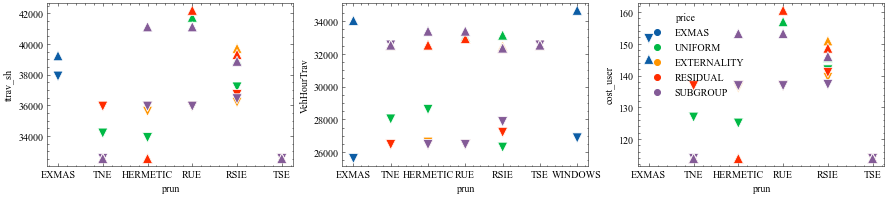

In [68]:
fig, axes = plt.subplots(1,3, figsize = (15,3))
for i, KPI in enumerate(['ttrav_sh','VehHourTrav', 'cost_user']):
    sns.scatterplot(y = KPI, x = 'prun', hue = 'price', data = KPIs[KPIs.minmax == 'min'], ax = axes[i], marker = 'v', s= 100, legend = False)
    sns.scatterplot(y = KPI, x = 'prun', hue = 'price', data = KPIs[KPIs.minmax == 'max'], ax = axes[i], marker = '^', s=100)
    if i <2: 
        axes[i].get_legend().remove()

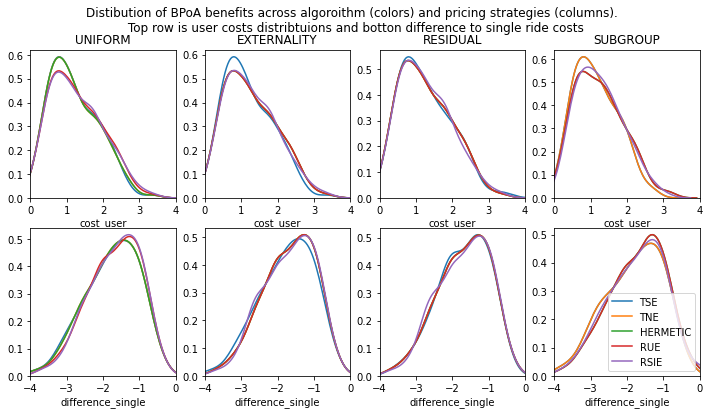

In [5]:
fig, ax = plt.subplots(2,4,figsize=(12,6))
rm['difference_single'] = rm['cost_user'] - rm['cost_single']

PRICINGS = ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']
for col in rm.columns:
    if '-' in col:
        for row, kpi in enumerate(['cost_user','difference_single']):
            
            PRICING, ALGO, _ , obj = col.split('-')
            if PRICING in PRICINGS:
                if obj == 'min':
                    j = PRICINGS.index(PRICING)
                    ax[0][j].set_title(PRICING)
                    sns.distplot(rm[rm[col] == 1][kpi],ax = ax[row][j], label = col.split('-')[1] if (j == 3) and (row == 1) else None, kde = True, hist = False) 
ax[0][1].set_xlim((0,4))
ax[0][2].set_xlim((0,4))
ax[0][3].set_xlim((0,4))
ax[0][0].set_xlim((0,4))
ax[1][1].set_xlim((-4,0))
ax[1][2].set_xlim((-4,0))
ax[1][3].set_xlim((-4,0))
ax[1][0].set_xlim((-4,0))
_ = fig.suptitle('Distibution of BPoA benefits across algoroithm (colors) and pricing strategies (columns). \n Top row is user costs distribtuions and botton difference to single ride costs')

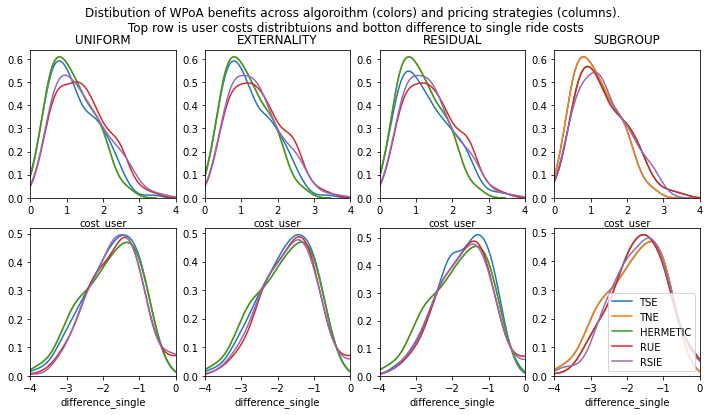

In [8]:
fig, ax = plt.subplots(2,4,figsize=(12,6))
rm['difference_single'] = rm['cost_user'] - rm['cost_single']

PRICINGS = ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']
for col in rm.columns:
    if '-' in col:
        for row, kpi in enumerate(['cost_user','difference_single']):
            
            PRICING, ALGO, _ , obj = col.split('-')
            if PRICING in PRICINGS:
                if obj == 'max':
                    j = PRICINGS.index(PRICING)
                    ax[0][j].set_title(PRICING)
                    sns.distplot(rm[rm[col] == 1][kpi],ax = ax[row][j], label = col.split('-')[1] if (j == 3) and (row == 1) else None, kde = True, hist = False) 
ax[0][1].set_xlim((0,4))
ax[0][2].set_xlim((0,4))
ax[0][3].set_xlim((0,4))
ax[0][0].set_xlim((0,4))
ax[1][1].set_xlim((-4,0))
ax[1][2].set_xlim((-4,0))
ax[1][3].set_xlim((-4,0))
ax[1][0].set_xlim((-4,0))
_ = fig.suptitle('Distibution of WPoA benefits across algoroithm (colors) and pricing strategies (columns). \n Top row is user costs distribtuions and botton difference to single ride costs')

In [18]:
KPIs[(KPIs.algo == 'TNE') & (KPIs.minmax == 'min')]

,ttrav_sh,cost_user,degree,u_veh,costs_veh,VehHourTrav,VehHourTrav_ns,PassHourTrav,PassHourTrav_ns,PassUtility,PassUtility_ns,mean_lambda,revenue_s,revenue_ns,Fare_Discount,nR,SINGLE,PAIRS,TRIPLES,QUADRIPLES,QUINTETS,PLUS5,shared_ratio,fleet_size_nonshared,fleet_size_shared,lambda_shared,_typ,dtype,pricing,algo,minmax,obj
UNIFORM-TNE-UNIFORM-min,0.967916,0.960488,3.52,91074.0,496.58670,90684,98953,101126,98953,1520.86325,1535.327,0.321343,118743.6,148429.5,-0.2,300,248,26,0,0,0,0,0.173333,73.0,68.0,0.321343,DotMap(),DotMap(),UNIFORM,TNE,min,UNIFORM
EXTERNALITY-TNE-EXTERNALITY-min,0.998378,1.008529,4.20,85587.0,461.42085,84687,98953,103407,98953,1502.21060,1535.327,0.258230,118743.6,148429.5,-0.2,300,180,60,0,0,0,0,0.400000,73.0,62.0,0.258230,DotMap(),DotMap(),EXTERNALITY,TNE,min,EXTERNALITY
RESIDUAL-TNE-RESIDUAL-min,0.998378,1.008529,4.20,85587.0,461.42085,84687,98953,103407,98953,1502.21060,1535.327,0.258230,118743.6,148429.5,-0.2,300,180,60,0,0,0,0,0.400000,73.0,62.0,0.258230,DotMap(),DotMap(),RESIDUAL,TNE,min,RESIDUAL
SUBGROUP-TNE-SUBGROUP-min,0.944642,0.917188,3.00,98953.0,540.23615,98953,98953,98953,98953,1535.32700,1535.327,NaN,118743.6,148429.5,-0.2,300,300,0,0,0,0,0,0.000000,73.0,73.0,0.000000,DotMap(),DotMap(),SUBGROUP,TNE,min,SUBGROUP


<AxesSubplot:>

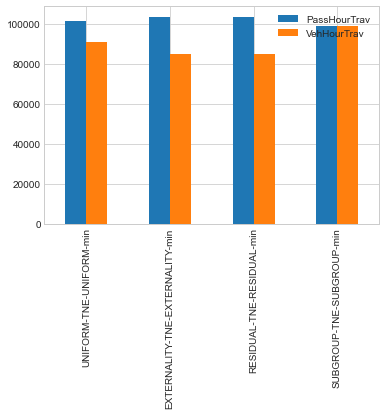

In [24]:
to_plot = KPIs[(KPIs.algo == 'TNE') & (KPIs.minmax == 'min')][['PassHourTrav','VehHourTrav']]
to_plot.plot(kind='bar')

<AxesSubplot:>

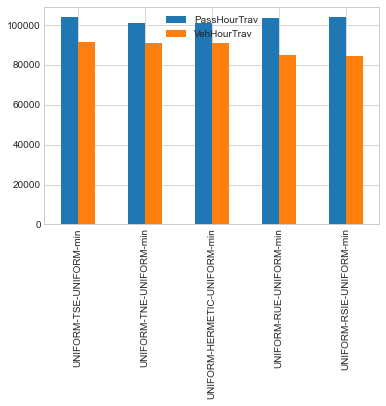

In [23]:
to_plot = KPIs[(KPIs.pricing == 'UNIFORM') & (KPIs.minmax == 'min')][['PassHourTrav','VehHourTrav']]
to_plot.plot(kind='bar')

<AxesSubplot:>

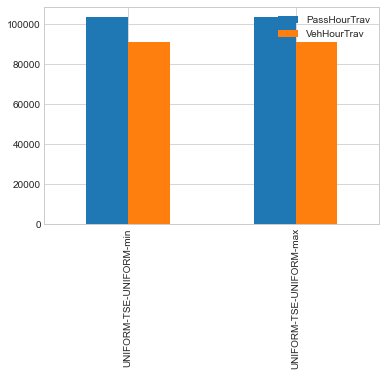

In [25]:
to_plot = KPIs[(KPIs.pricing == 'UNIFORM') & (KPIs.algo == 'TSE')][['PassHourTrav','VehHourTrav']]
to_plot.plot(kind='bar')

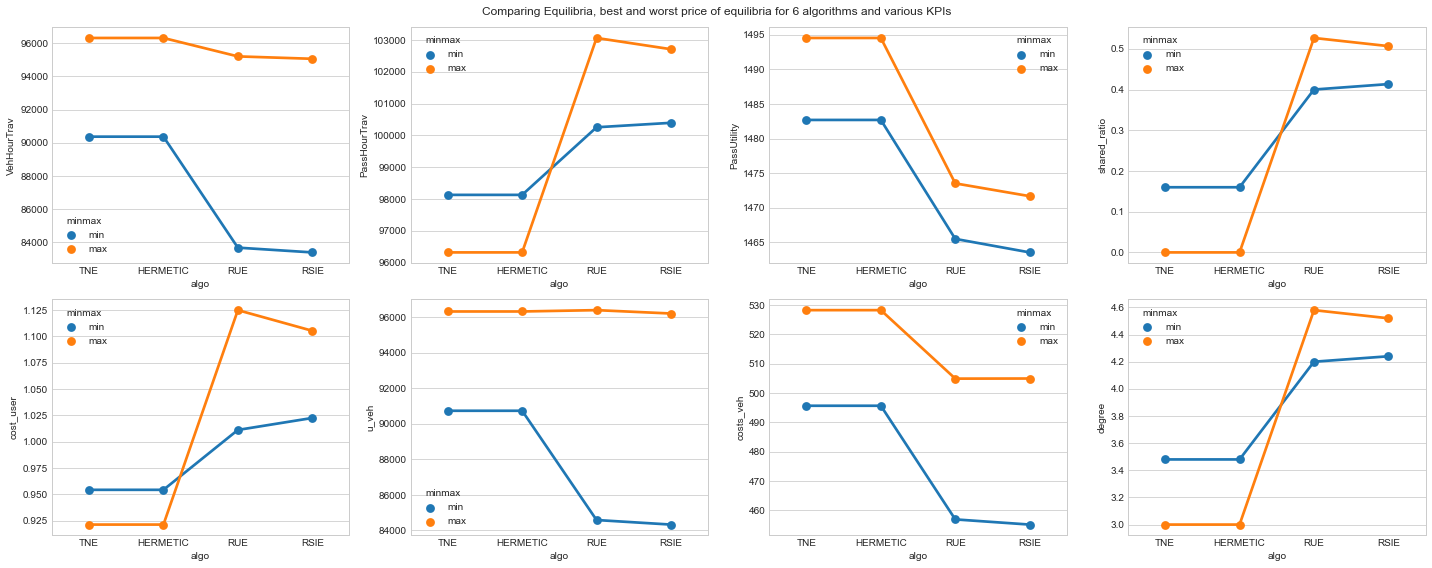

In [9]:
def plot_KPIs(pricing = 'UNIFORM'):
    plt.style.use('seaborn-whitegrid')
    KPIs = pd.read_csv('ExMAS/extras/PIPE_KPIs.csv', index_col = 0)
    KPIs = KPIs[~(KPIs.algo == 'TSE')]
    KPIs.obj = KPIs.obj.apply(lambda x: 'costs_user' if x == 'u_pax' else x)
    KPIs.obj = KPIs.obj.apply(lambda x: 'costs_veh' if x == 'u_veh' else x)
    to_plot = KPIs[KPIs.pricing == 'UNIFORM']
    fig, axes = plt.subplots(2,4,figsize = (20,8))
    axes = axes.flatten()
    sns.pointplot(y='VehHourTrav',x = 'algo', data = to_plot, ax = axes[0], hue = 'minmax')
    
    sns.pointplot(y='PassHourTrav',x = 'algo', data = to_plot, ax = axes[1], hue = 'minmax')
    sns.pointplot(y='PassUtility',x = 'algo', data = to_plot, ax = axes[2], hue = 'minmax')
    sns.pointplot(y='shared_ratio',x = 'algo', data = to_plot, ax = axes[3], hue = 'minmax')
    sns.pointplot(y='cost_user',x = 'algo', data = to_plot, ax = axes[4], hue = 'minmax')
    sns.pointplot(y='u_veh',x = 'algo', data = to_plot, ax = axes[5], hue = 'minmax')
    sns.pointplot(y='costs_veh',x = 'algo', data = to_plot, ax = axes[6], hue = 'minmax')
    sns.pointplot(y='degree',x = 'algo', data = to_plot, ax = axes[7], hue = 'minmax')
    fig.suptitle('Comparing Equilibria, best and worst price of equilibria for 6 algorithms and various KPIs')
    plt.tight_layout()
    

plot_KPIs()

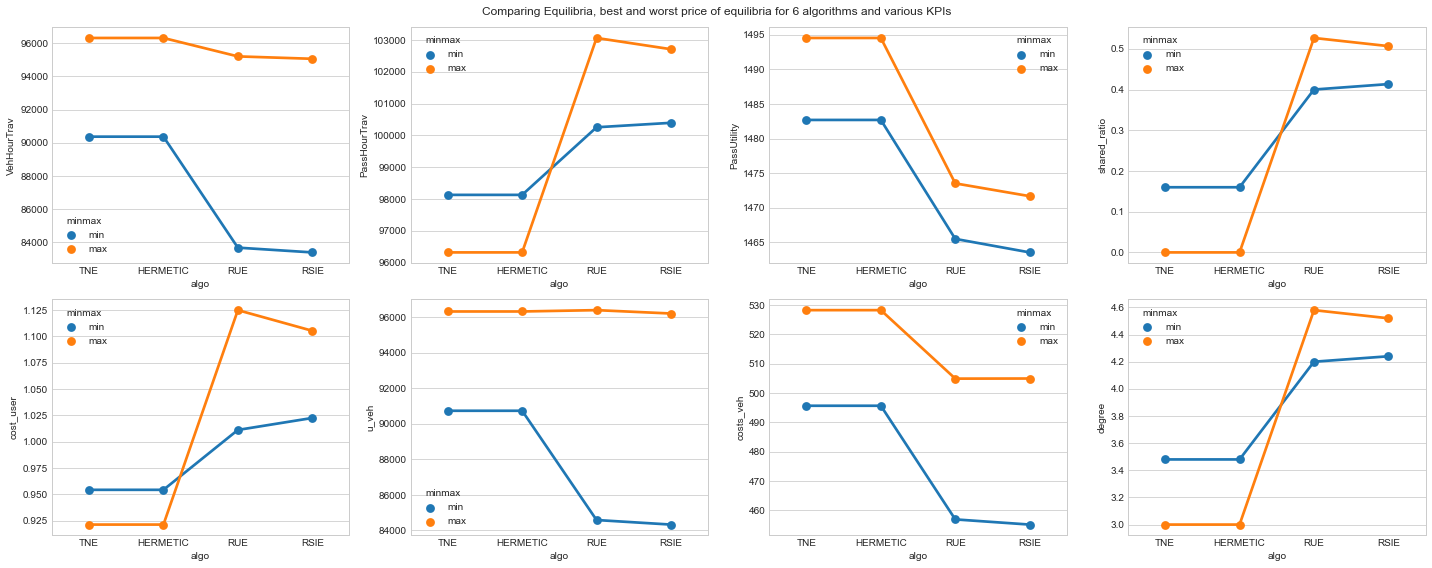

In [51]:
plot_KPIs(pricing = 'EXTERNALITY')

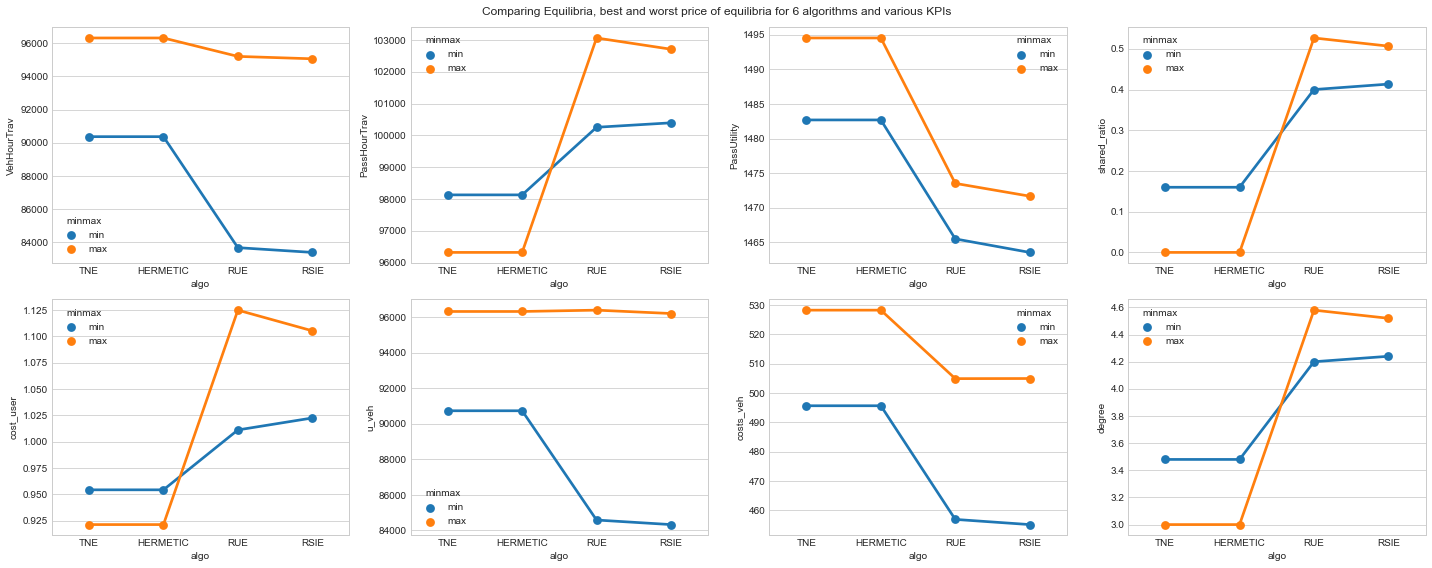

In [50]:
plot_KPIs(pricing = 'RESIDUAL')

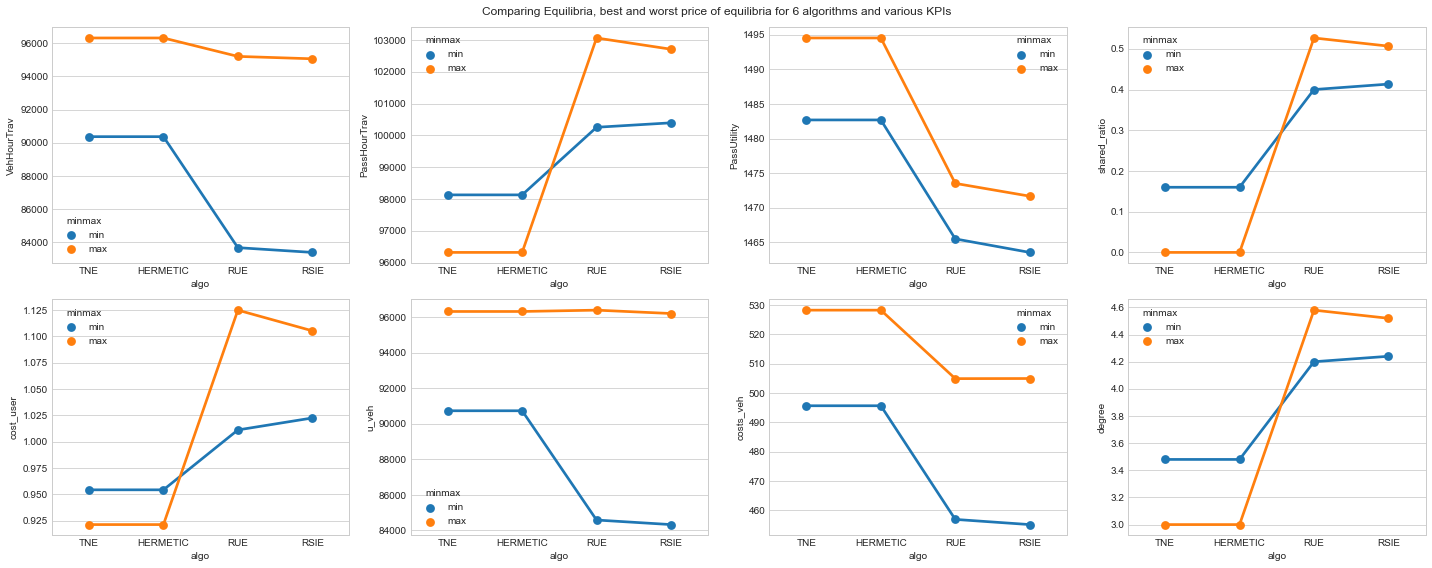

In [52]:
plot_KPIs(pricing = 'SUBGROUP')

---
(c) Rafał Kucharski, Delft, 2020